In [12]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [13]:
df = pd.read_csv('/Users/sachacollinson/Downloads/simulated_transaction_2024.csv')

In [14]:
df

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name
0,01/01/2023,00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home
1,01/01/2023,00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique
2,01/01/2023,00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN
3,01/01/2023,00:00,283027736.0,1787.000000,780.00,472213568.0,NaN
4,01/01/2023,00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face
...,...,...,...,...,...,...,...
230591,06/12/2023,20:54,581655972.0,45935.206861,-41.06,NaN,Tesco
230592,06/12/2023,20:55,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local
230593,06/12/2023,21:05,824916823.0,9709.172159,-32.94,NaN,Deliveroo
230594,06/12/2023,21:13,366550080.0,26834.165794,-19.25,NaN,Amazon


In [15]:
# Ensure TransactionDate is in datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)  # Adjusting for day-first format
end_date = pd.Timestamp('2025-12-31')

# RFM Calculation
rfm = df.groupby('Account No').agg({
    'Account No': 'count',
    'Amount': 'sum'
}).rename(columns={'Account No': 'Frequency',
                   'Amount': 'MonetaryValue'})

# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
rfm['M_Score'] = rfm['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
rfm['RFM_Score'] =  rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the final RFM segmentation
print(rfm.head())

             Frequency  MonetaryValue  F_Score  M_Score RFM_Score
Account No                                                       
101531259.0        123        -716.08        4        2        42
104832000.0        164       -4565.52        3        1        31
105375973.0        158        -193.77        3        3        33
106601471.0        193       10649.00        3        4        34
108481285.0        368       10038.92        1        4        14


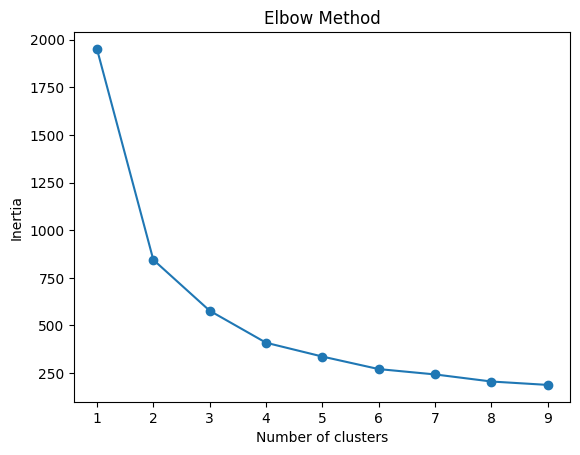

In [16]:
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[[ 'Frequency', 'MonetaryValue']])

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Examine cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=[ 'Frequency', 'MonetaryValue'])
print(centroids)

# Analyze cluster characteristics
for cluster in sorted(rfm['Cluster'].unique()):
    print(f"\nCluster {cluster} Characteristics:")
    cluster_data = rfm[rfm['Cluster'] == cluster]
    print(cluster_data.describe())

    Frequency  MonetaryValue
0  353.240964    3779.981566
1  438.250000   18723.358333
2  164.233281   -1600.879907

Cluster 0 Characteristics:
        Frequency  MonetaryValue     F_Score     M_Score  Cluster
count  249.000000     249.000000  249.000000  249.000000    249.0
mean   353.240964    3779.981566    1.333333    3.449799      0.0
std     95.708511    3658.097143    0.497305    0.700295      0.0
min    192.000000   -2303.140000    1.000000    1.000000      0.0
25%    280.000000     680.060000    1.000000    3.000000      0.0
50%    331.000000    3212.530000    1.000000    4.000000      0.0
75%    418.000000    6670.430000    2.000000    4.000000      0.0
max    695.000000   14312.370000    3.000000    4.000000      0.0

Cluster 1 Characteristics:
        Frequency  MonetaryValue    F_Score  M_Score  Cluster
count   84.000000      84.000000  84.000000     84.0     84.0
mean   438.250000   18723.358333   1.142857      4.0      1.0
std    119.137955    7992.181970   0.384735     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


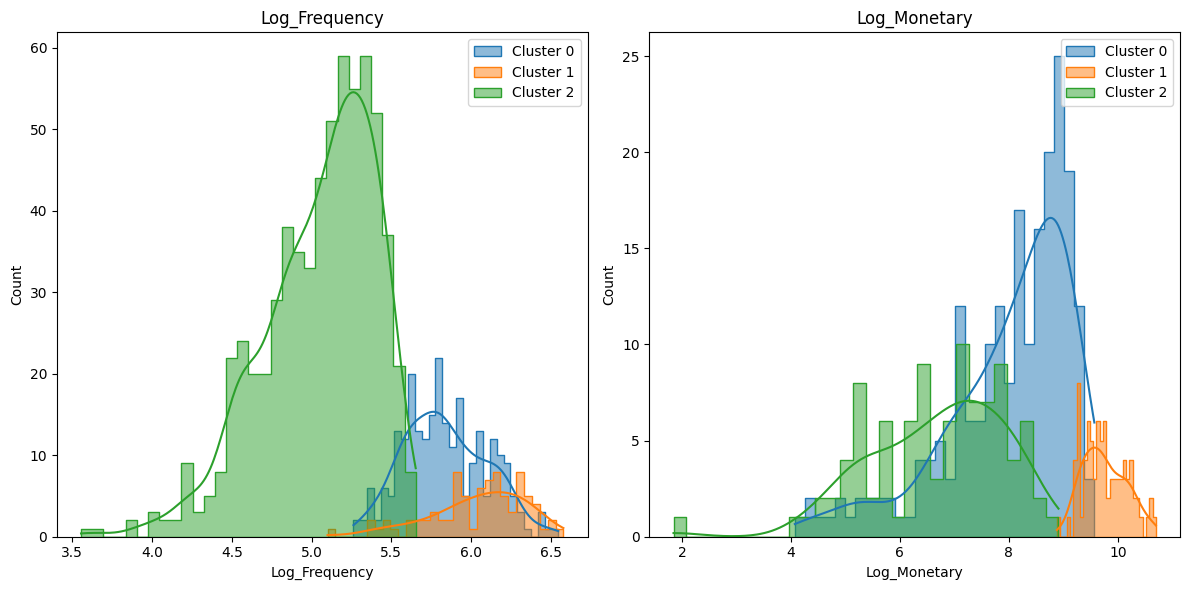

In [18]:
# Apply log transformation to 'Frequency' and 'Monetary' to handle wide ranges
rfm['Log_Frequency'] = np.log1p(rfm['Frequency'])
rfm['Log_Monetary'] = np.log1p(rfm['MonetaryValue'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Increased figure size
axes = axes.flatten()

features = [ 'Log_Frequency', 'Log_Monetary']
for i, feature in enumerate(features):
    for cluster in range(kmeans.n_clusters):
        # Adjust bin size for better visualization
        sns.histplot(rfm[rfm['Cluster'] == cluster][feature], ax=axes[i], label=f'Cluster {cluster}', kde=True, bins=30, element='step')
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

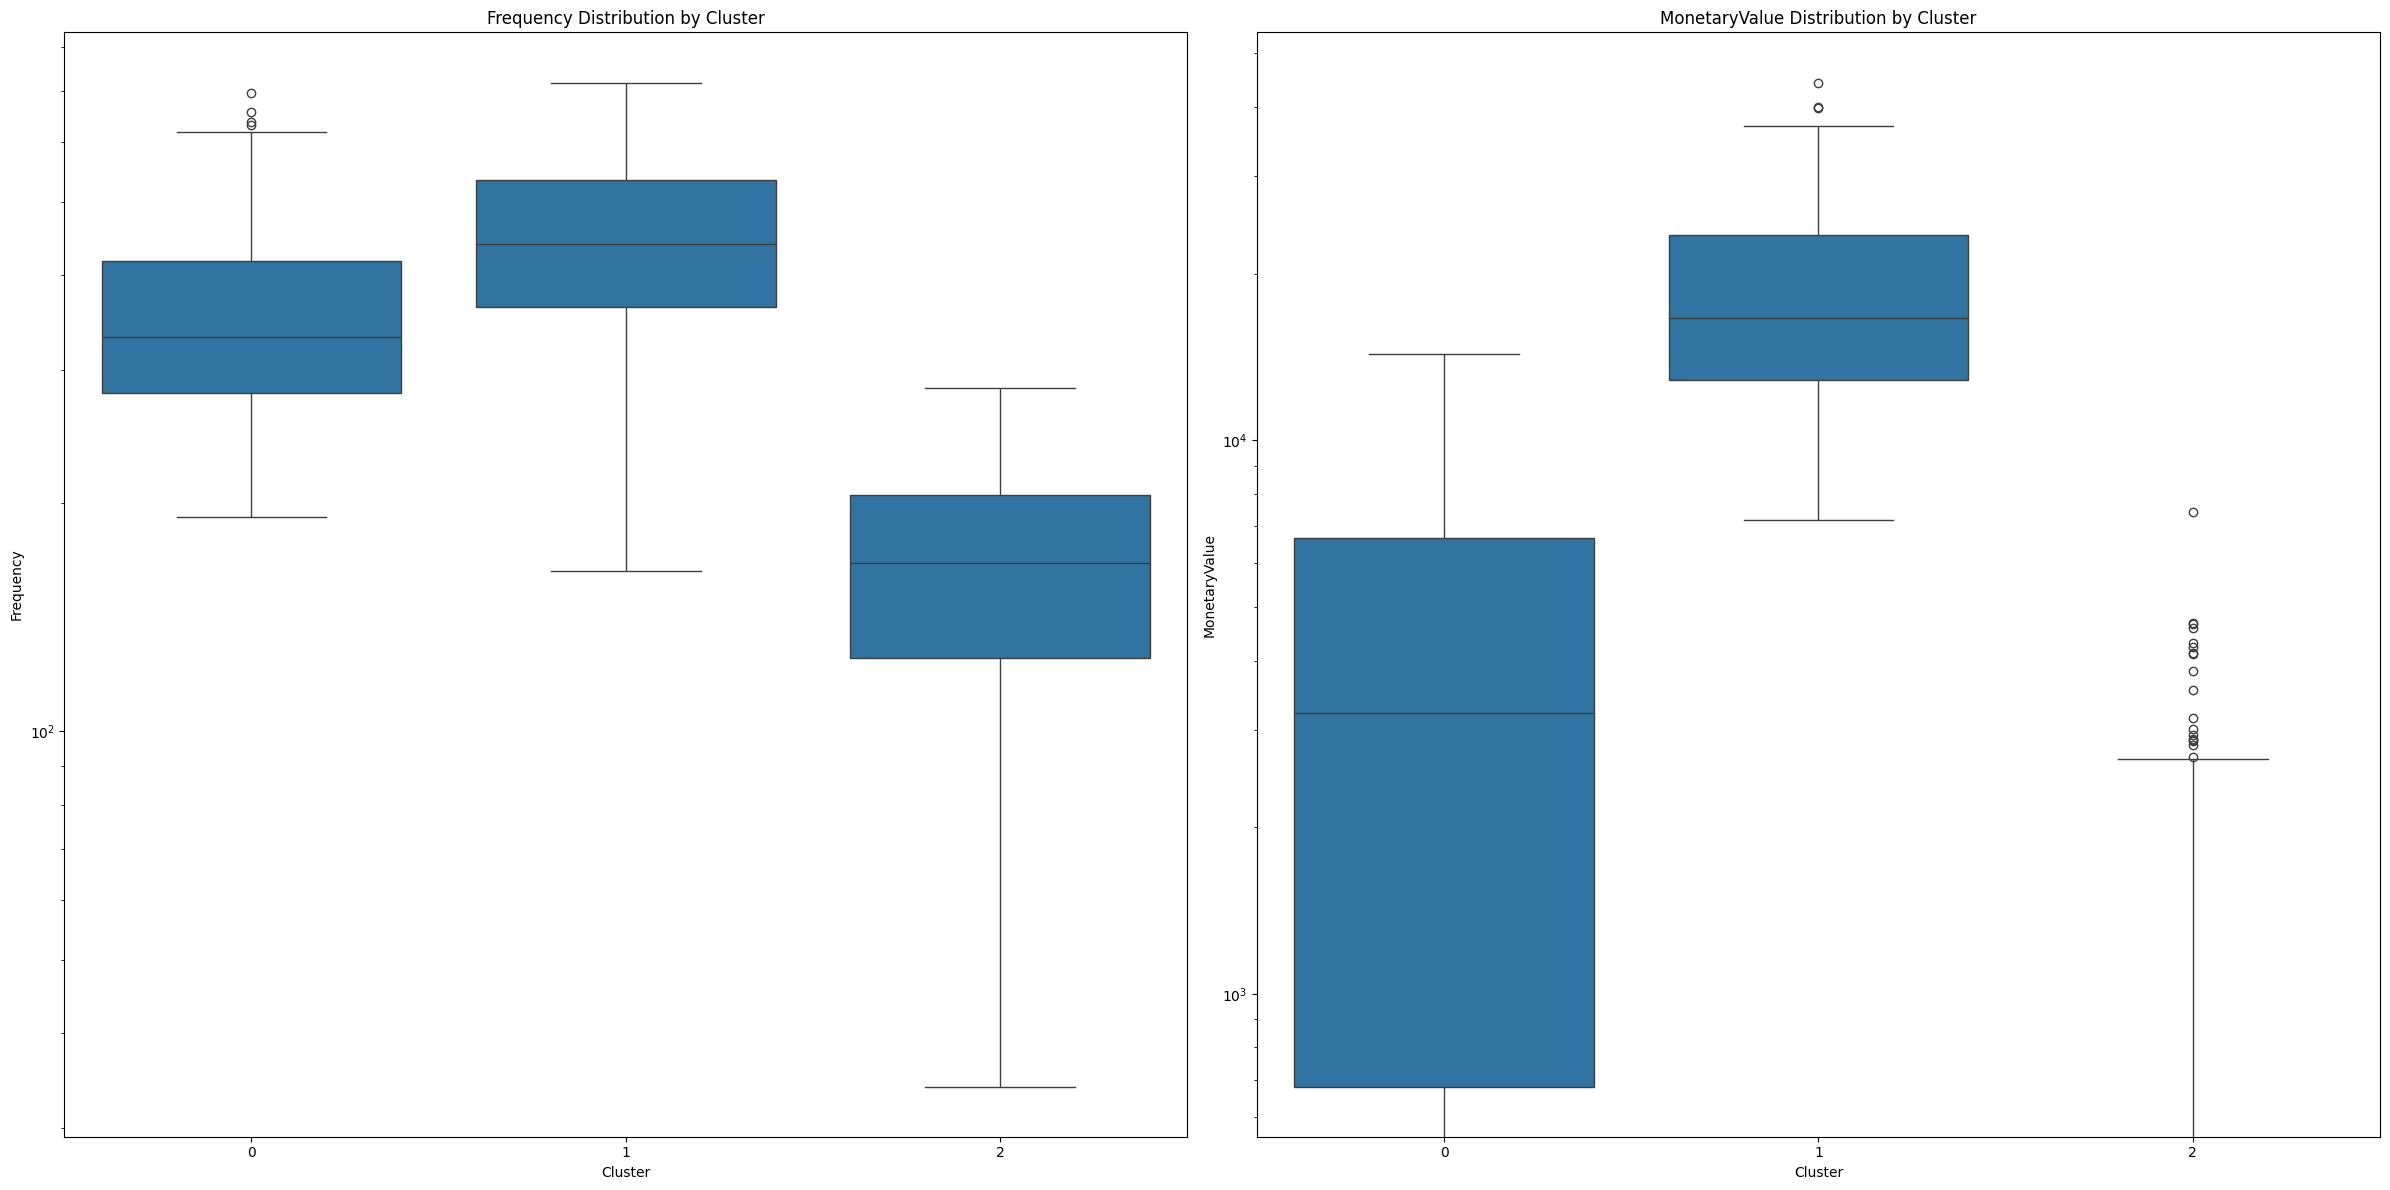

In [19]:
features = ['Frequency', 'MonetaryValue']
fig, axes = plt.subplots(1, 2, figsize=(24, 12))  # Adjust the size as needed

for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=rfm, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Cluster')
    # Optional: To improve readability, you might log-transform Frequency and Monetary values
    if feature in ['Frequency', 'MonetaryValue']:
        axes[i].set_yscale('log')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [43]:
# RFM Calculation
df.dropna(subset=['Balance', 'Amount','Account No'], inplace=True)
fmb = df.groupby('Account No').agg({
    'Account No': 'count',
    'Amount': 'sum',
    'Balance': 'mean'
}).rename(columns={'Account No': 'Frequency',
                   'Amount': 'MonetaryValue'})

# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = fmb.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
fmb['F_Score'] = fmb['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
fmb['M_Score'] = fmb['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
fmb['RFM_Score'] =  fmb['F_Score'].astype(str) + fmb['M_Score'].astype(str)

# Display the final RFM segmentation
print(fmb.head())

             Frequency  MonetaryValue      Balance  F_Score  M_Score RFM_Score
Account No                                                                    
101531259.0        122        -716.08   256.662295        4        2        42
104832000.0        164       -4565.52 -1188.593268        3        1        31
105375973.0        158        -193.77   110.995337        3        3        33
106601471.0        192       10649.00  6837.358765        3        4        34
108481285.0        368       10038.92  6830.116572        1        4        14


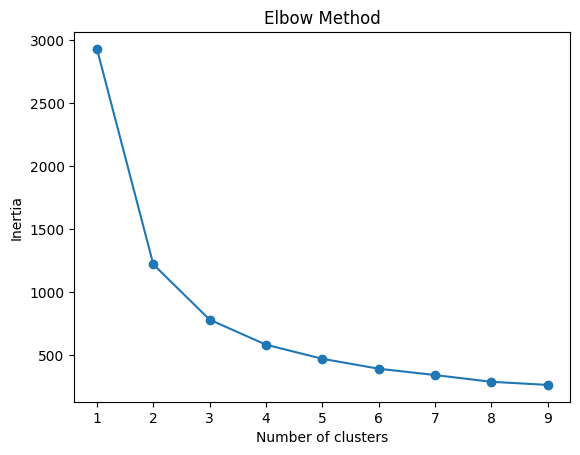

In [46]:
# Standardize the data
scaler = StandardScaler()
fmb_scaled = scaler.fit_transform(fmb[[ 'Frequency', 'MonetaryValue','Balance']])

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(fmb_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [36]:
kmeans = KMeans(n_clusters=3, random_state=42)
fmb['Cluster'] = kmeans.fit_predict(fmb_scaled)

# Examine cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=[ 'Frequency', 'MonetaryValue','Balance'])
print(centroids)

# Analyze cluster characteristics
for cluster in sorted(fmb['Cluster'].unique()):
    print(f"\nCluster {cluster} Characteristics:")
    cluster_data = fmb[fmb['Cluster'] == cluster]
    print(cluster_data.describe())

    Frequency  MonetaryValue       Balance
0  388.500000    5455.192798   4759.501361
1  405.949153   21891.276441  14421.809184
2  173.496423   -1402.298670    321.917709

Cluster 0 Characteristics:
        Frequency  MonetaryValue      Balance     F_Score     M_Score  \
count  218.000000     218.000000   218.000000  218.000000  218.000000   
mean   388.500000    5455.192798  4759.501361    1.201835    3.660550   
std    105.803846    4054.989087  2293.196599    0.424586    0.595222   
min    191.000000   -2303.140000   399.870108    1.000000    1.000000   
25%    316.500000    2196.745000  2751.483009    1.000000    3.000000   
50%    378.000000    5289.245000  4672.578797    1.000000    4.000000   
75%    466.750000    8497.175000  6544.087450    1.000000    4.000000   
max    695.000000   14328.360000  9693.601702    3.000000    4.000000   

       Cluster  Log_Frequency  Log_Monetary  Log_Balance  
count    218.0     218.000000    198.000000   218.000000  
mean       0.0       5.9

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


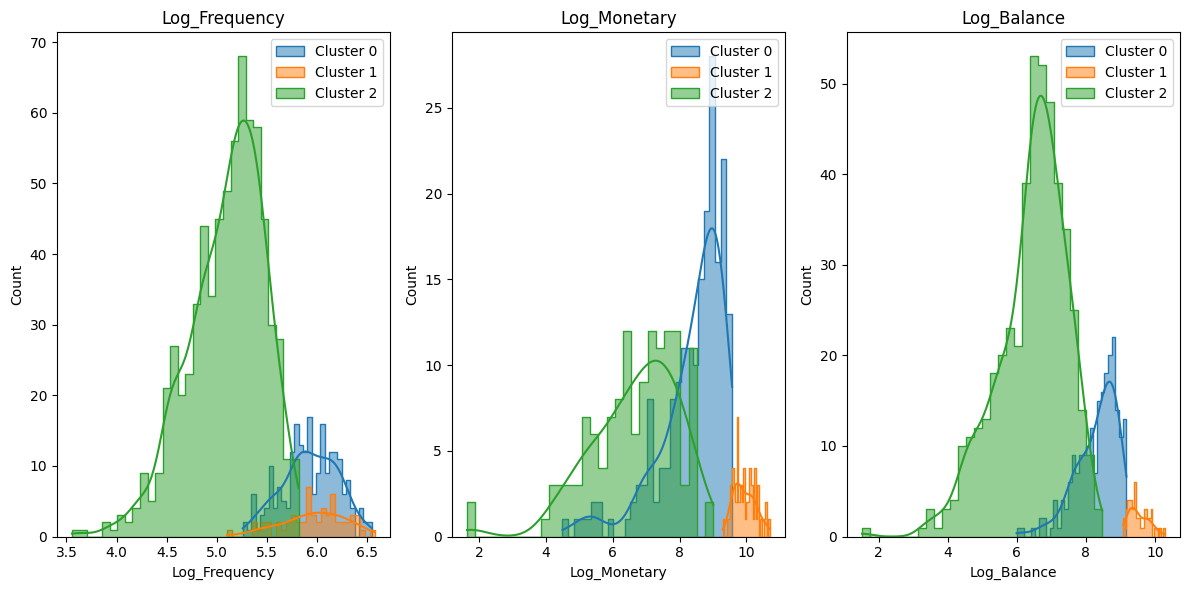

In [38]:
# Apply log transformation to 'Frequency' and 'Monetary' to handle wide ranges
fmb['Log_Frequency'] = np.log1p(fmb['Frequency'])
fmb['Log_Monetary'] = np.log1p(fmb['MonetaryValue'])
fmb['Log_Balance'] = np.log1p(fmb['Balance'])

fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Increased figure size
axes = axes.flatten()

fmb_features = [ 'Log_Frequency', 'Log_Monetary','Log_Balance']
for i, feature in enumerate(fmb_features):
    for cluster in range(kmeans.n_clusters):
        # Adjust bin size for better visualization
        sns.histplot(fmb[fmb['Cluster'] == cluster][feature], ax=axes[i], label=f'Cluster {cluster}', kde=True, bins=30, element='step')
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

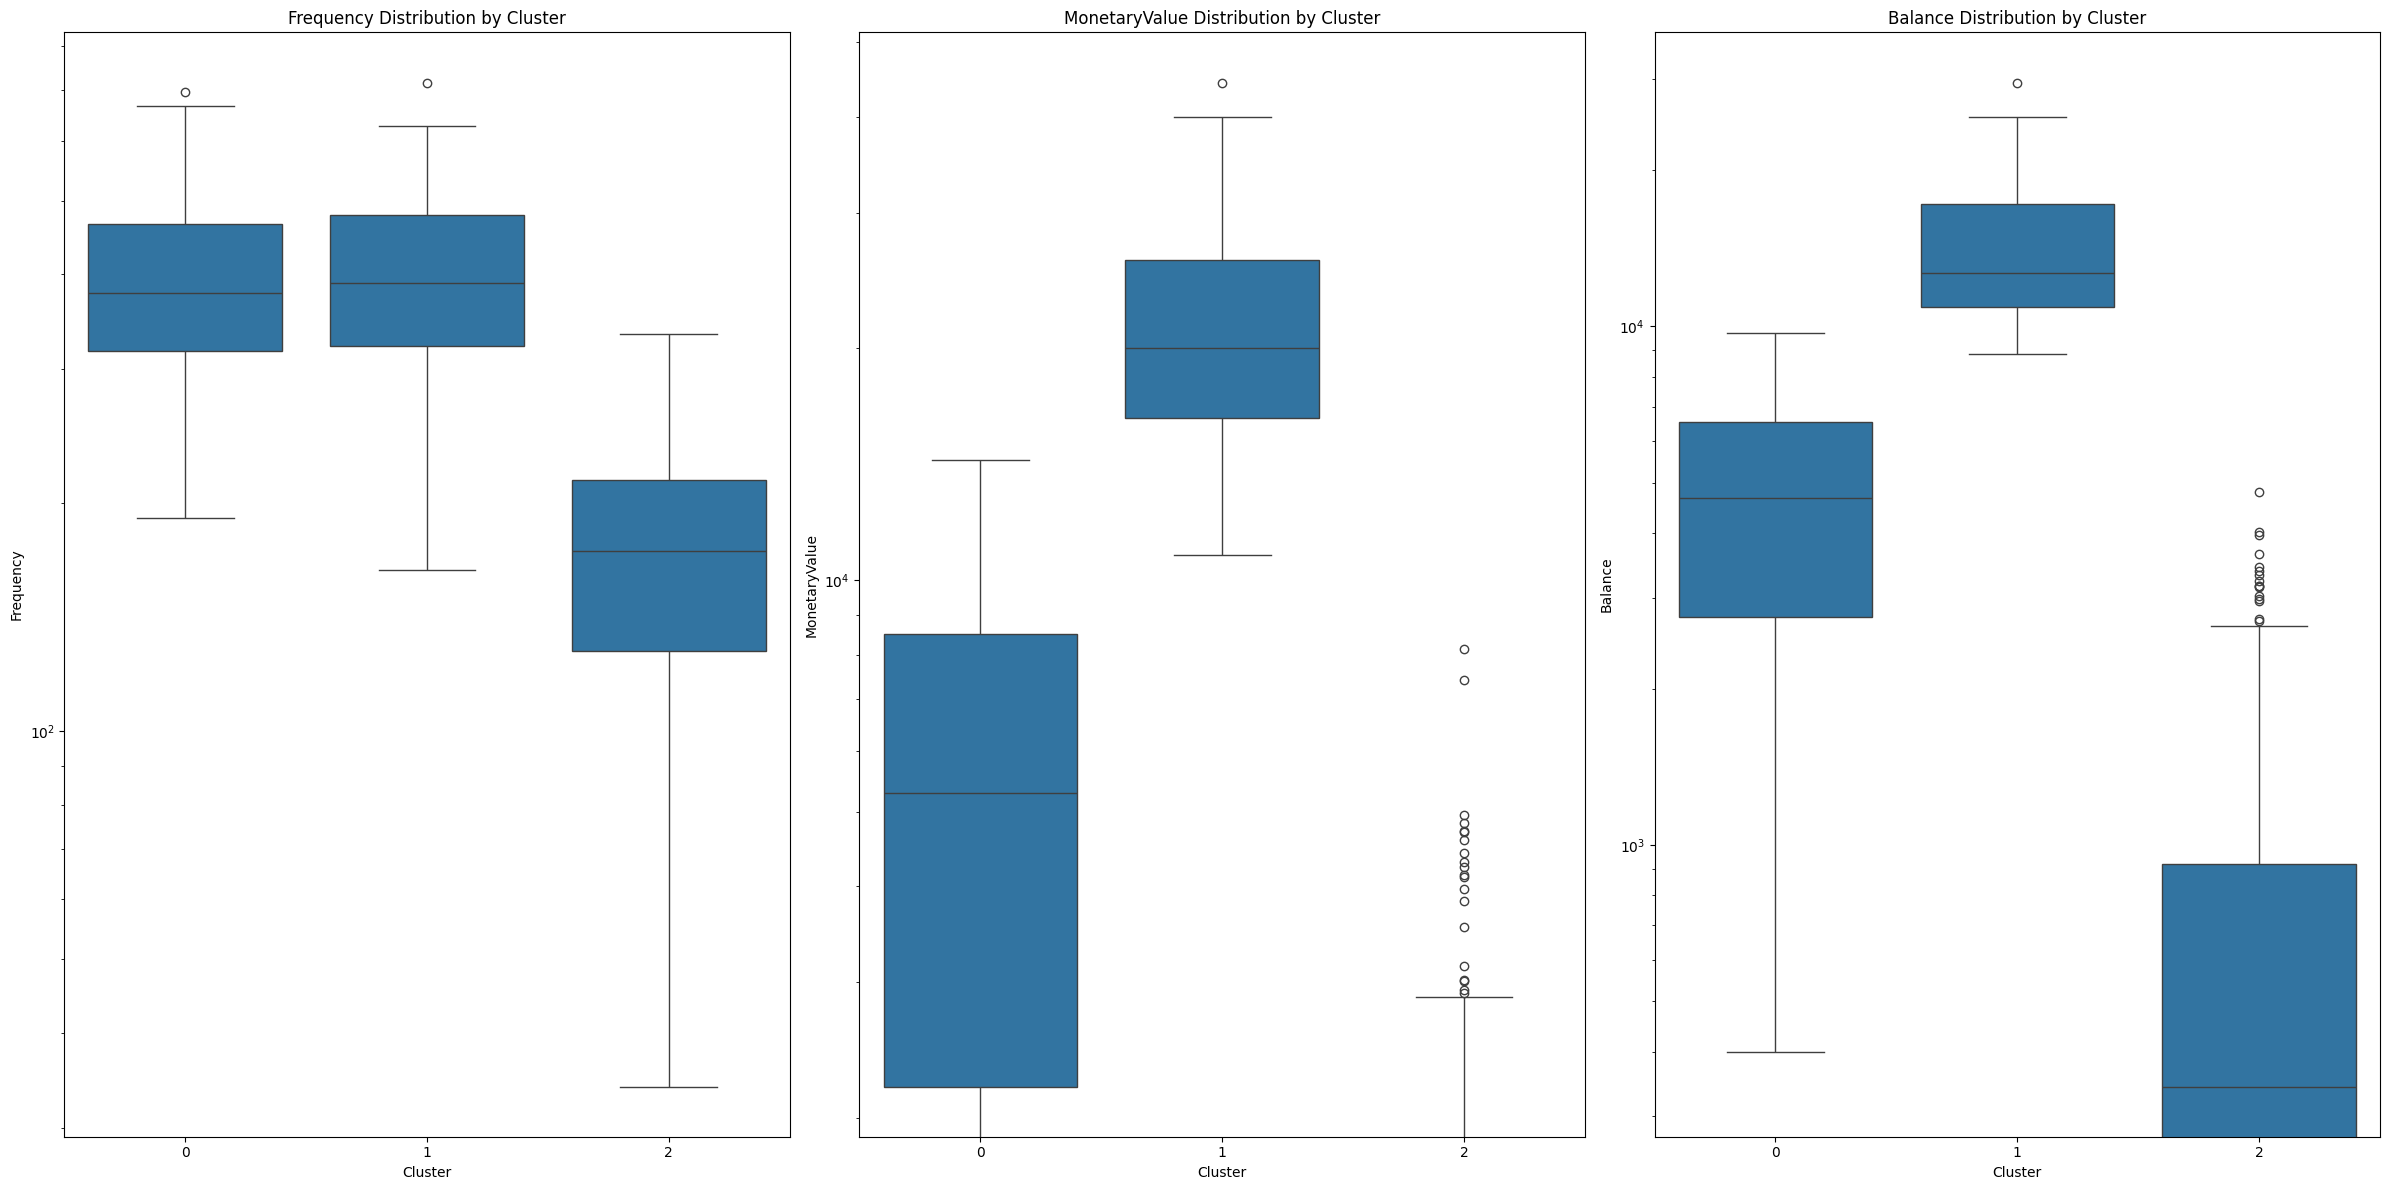

In [39]:
features = ['Frequency', 'MonetaryValue', 'Balance']
fig, axes = plt.subplots(1, 3, figsize=(24, 12))  # Adjust the size as needed

for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=fmb, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Cluster')
    # Optional: To improve readability, you might log-transform Frequency and Monetary values
    if feature in ['Frequency', 'MonetaryValue','Balance']:
        axes[i].set_yscale('log')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [41]:
# Separate the dataset into two based on the Amount
outgoing_payments = df[df['Amount'] < 0]
incoming_payments = df[df['Amount'] > 0]

# Display the first few rows of each dataset to confirm
(outgoing_payments.head(), incoming_payments.head())

(         Date Timestamp   Account No  Balance  Amount  Third Party Account No  \
 2  2023-01-01     00:00  472213568.0   3012.0  -780.0             283027736.0   
 7  2023-01-01     00:00  768271776.0   2840.0  -780.0             215404070.0   
 11 2023-01-01     00:00  350921975.0   1998.5  -460.0             633362865.0   
 13 2023-01-01     00:00  455831435.0   2603.1  -650.0             442079728.0   
 18 2023-01-01     00:00  172084472.0   1149.0 -1300.0             407574996.0   
 
    Third Party Name  
 2               NaN  
 7               NaN  
 11              NaN  
 13              NaN  
 18              NaN  ,
         Date Timestamp   Account No  Balance   Amount  Third Party Account No  \
 0 2023-01-01     00:00  678330503.0  2971.00  1584.00                     NaN   
 1 2023-01-01     00:00  472213568.0  3792.00  1950.00                     NaN   
 3 2023-01-01     00:00  283027736.0  1787.00   780.00             472213568.0   
 4 2023-01-01     00:00  624500124.0  3

## Outgoing Clustering

In [54]:
# RFM Calculation
outgoing_payments.dropna(subset=['Balance', 'Amount','Account No'], inplace=True)

out_fmb = outgoing_payments.groupby('Account No').agg({
    'Account No': 'count',
    'Amount': 'sum',
    'Balance': 'mean'
}).rename(columns={'Account No': 'Frequency',
                   'Amount': 'MonetaryValue'})

out_fmb['Absolute_MonetaryValue'] = out_fmb['MonetaryValue'].abs()
# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = out_fmb.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
out_fmb['F_Score'] = out_fmb['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
out_fmb['M_Score'] = out_fmb['Absolute_MonetaryValue'].apply(rfm_score, args=('Absolute_MonetaryValue', quantiles,))

# Combine RFM scores
out_fmb['RFM_Score'] =  out_fmb['F_Score'].astype(str) + out_fmb['M_Score'].astype(str)

# Display the final RFM segmentation
print(out_fmb.head())

             Frequency  MonetaryValue      Balance  Absolute_MonetaryValue  \
Account No                                                                   
101531259.0        111      -17683.58   168.661032                17683.58   
104832000.0        150      -25115.52 -1300.619324                25115.52   
105375973.0        147      -10093.77    89.801179                10093.77   
106601471.0        181       -7776.00  6806.817093                 7776.00   
108481285.0        345      -15065.08  6830.244445                15065.08   

             F_Score  M_Score RFM_Score  
Account No                               
101531259.0        4        2        42  
104832000.0        3        4        34  
105375973.0        3        1        31  
106601471.0        3        1        31  
108481285.0        1        2        12  


/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_11258/433112580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outgoing_payments.dropna(subset=['Balance', 'Amount','Account No'], inplace=True)


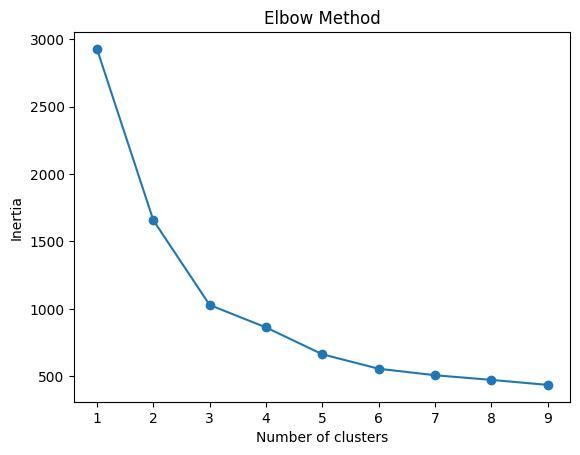

In [55]:
# Standardize the data
scaler = StandardScaler()
out_fmb_scaled = scaler.fit_transform(out_fmb[[ 'Frequency', 'Absolute_MonetaryValue','Balance']])

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(out_fmb_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [56]:
kmeans = KMeans(n_clusters=3, random_state=42)
out_fmb['Cluster'] = kmeans.fit_predict(out_fmb_scaled)

# Examine cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=[ 'Frequency', 'Absolute_MonetaryValue','Balance'])
print(centroids)

# Analyze cluster characteristics
for cluster in sorted(out_fmb['Cluster'].unique()):
    print(f"\nCluster {cluster} Characteristics:")
    cluster_data = out_fmb[out_fmb['Cluster'] == cluster]
    print(cluster_data.describe())

    Frequency  Absolute_MonetaryValue      Balance
0  131.018927             7577.077224  -163.177132
1  427.666667            24368.863277  8717.108107
2  212.190871            24074.032469  1196.926921

Cluster 0 Characteristics:
        Frequency  MonetaryValue      Balance  Absolute_MonetaryValue  \
count  317.000000     317.000000   317.000000              317.000000   
mean   131.018927   -7577.077224  -163.177132             7577.077224   
std     42.953385    3603.407639  1265.402235             3603.407639   
min     34.000000  -17683.580000 -2771.750976             1156.060000   
25%     98.000000  -10093.770000  -881.528993             4445.890000   
50%    124.000000   -7557.340000  -109.644070             7557.340000   
75%    160.000000   -4445.890000   327.252766            10093.770000   
max    267.000000   -1156.060000  8729.402970            17683.580000   

          F_Score     M_Score  Cluster  
count  317.000000  317.000000    317.0  
mean     3.498423    1.23343

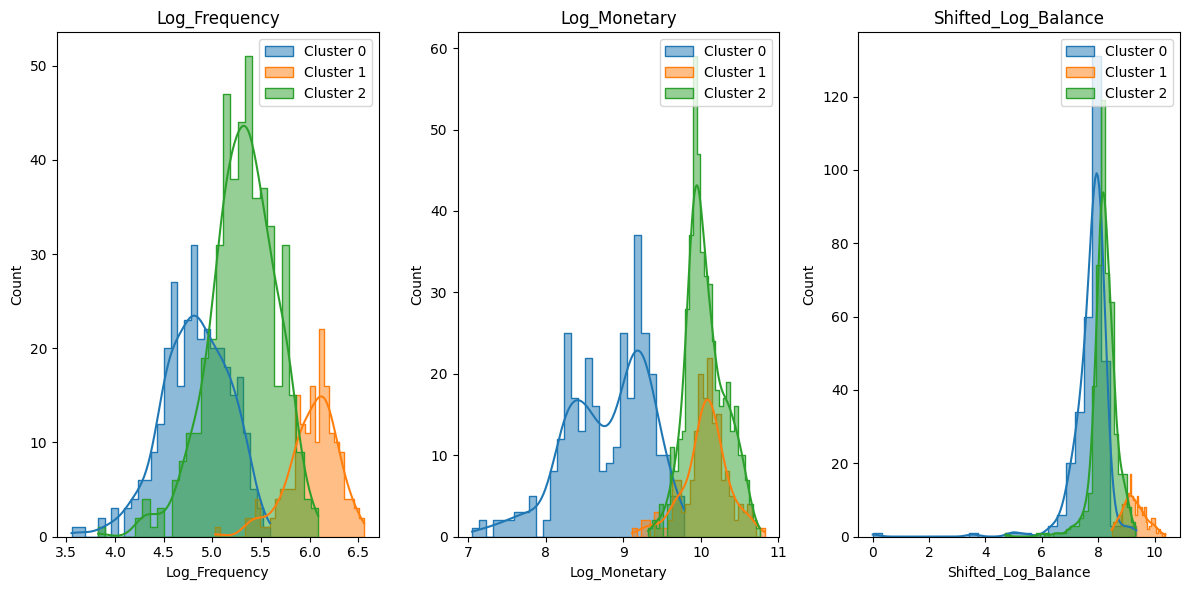

In [60]:
# Apply log transformation to 'Frequency' and 'Monetary' to handle wide ranges
out_fmb['Log_Frequency'] = np.log1p(out_fmb['Frequency'])
out_fmb['Log_Monetary'] = np.log1p(out_fmb['Absolute_MonetaryValue'])
min_balance = out_fmb['Balance'].min()
shift = abs(min_balance) + 1
out_fmb['Shifted_Log_Balance'] = np.log(out_fmb['Balance'] + shift)
fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Increased figure size
axes = axes.flatten()

fmb_features = [ 'Log_Frequency', 'Log_Monetary','Shifted_Log_Balance']
for i, feature in enumerate(fmb_features):
    for cluster in range(kmeans.n_clusters):
        # Adjust bin size for better visualization
        sns.histplot(out_fmb[out_fmb['Cluster'] == cluster][feature], ax=axes[i], label=f'Cluster {cluster}', kde=True, bins=30, element='step')
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Incoming clustering

/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_11258/1916829412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incoming_payments.dropna(subset=['Balance', 'Amount','Account No'], inplace=True)


             Frequency  MonetaryValue      Balance  F_Score  M_Score RFM_Score
Account No                                                                    
101531259.0         11        16967.5  1144.675041        4        2        42
104832000.0         14        20550.0    11.685906        1        3        13
105375973.0         11         9900.0   394.226366        4        1        41
106601471.0         11        18425.0  7339.908088        4        2        42
108481285.0         23        25104.0  6828.198478        1        3        13


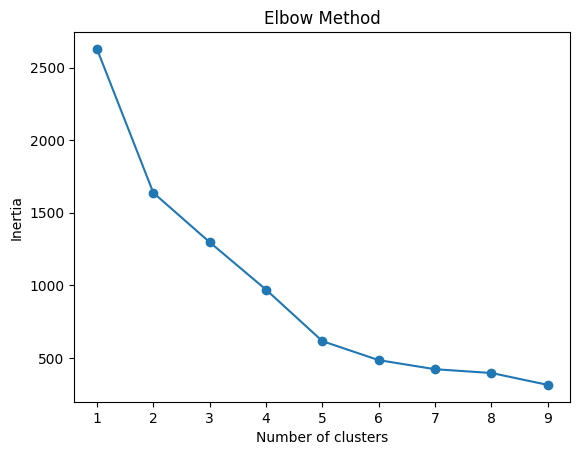

   Frequency  MonetaryValue       Balance
0  21.848485   26437.721212   3905.920936
1  12.179167   16402.707042   1366.339309
2   4.310345    5781.034483    385.951027
3  11.318182   50379.086364  16216.614349
4  11.831418   32650.546054   5739.562148

Cluster 0 Characteristics:
       Frequency  MonetaryValue       Balance  F_Score    M_Score  Cluster
count  33.000000      33.000000     33.000000     33.0  33.000000     33.0
mean   21.848485   26437.721212   3905.920936      1.0   2.969697      0.0
std     1.839178    7701.288111   3340.929099      0.0   1.045372      0.0
min    18.000000    9480.000000   -715.000184      1.0   1.000000      0.0
25%    21.000000   23130.000000   1148.653590      1.0   3.000000      0.0
50%    22.000000   28836.000000   3188.899212      1.0   3.000000      0.0
75%    23.000000   32319.600000   6242.346904      1.0   4.000000      0.0
max    24.000000   36160.000000  13138.634539      1.0   4.000000      0.0

Cluster 1 Characteristics:
        Frequency

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


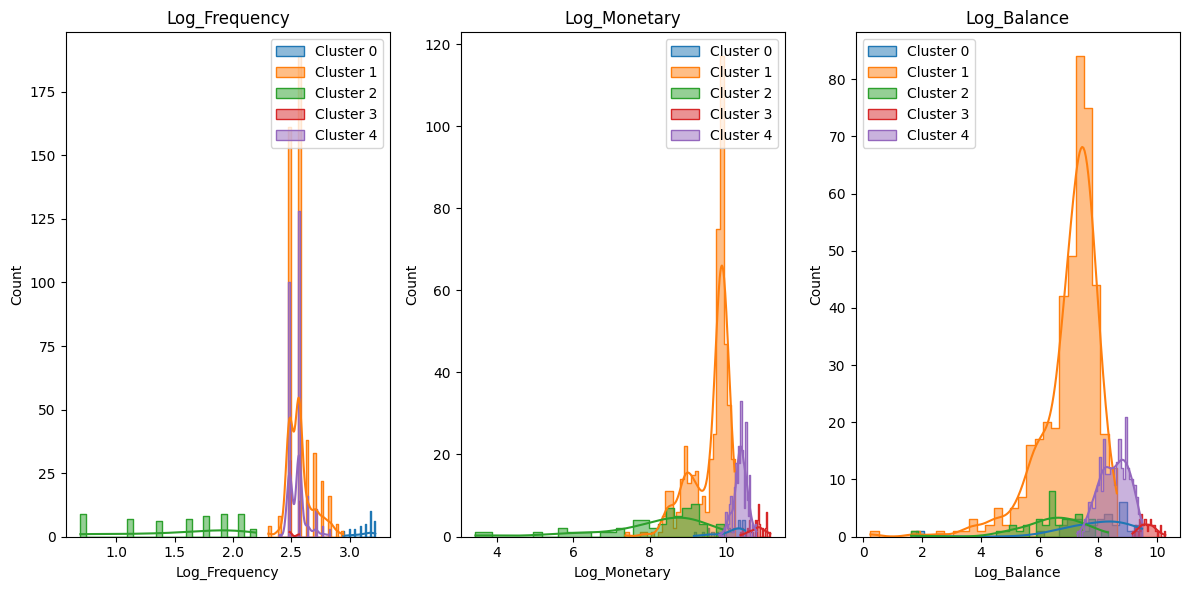

In [61]:
# RFM Calculation
incoming_payments.dropna(subset=['Balance', 'Amount','Account No'], inplace=True)
in_fmb = incoming_payments.groupby('Account No').agg({
    'Account No': 'count',
    'Amount': 'sum',
    'Balance': 'mean'
}).rename(columns={'Account No': 'Frequency',
                   'Amount': 'MonetaryValue'})

# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = in_fmb.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
in_fmb['F_Score'] = in_fmb['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
in_fmb['M_Score'] = in_fmb['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
in_fmb['RFM_Score'] =  in_fmb['F_Score'].astype(str) + in_fmb['M_Score'].astype(str)

# Display the final RFM segmentation
print(in_fmb.head())

# Standardize the data
scaler = StandardScaler()
in_fmb_scaled = scaler.fit_transform(in_fmb[[ 'Frequency', 'MonetaryValue','Balance']])

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(in_fmb_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
in_fmb['Cluster'] = kmeans.fit_predict(in_fmb_scaled)

# Examine cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=[ 'Frequency', 'MonetaryValue','Balance'])
print(centroids)

# Analyze cluster characteristics
for cluster in sorted(in_fmb['Cluster'].unique()):
    print(f"\nCluster {cluster} Characteristics:")
    cluster_data = in_fmb[in_fmb['Cluster'] == cluster]
    print(cluster_data.describe())


# Apply log transformation to 'Frequency' and 'Monetary' to handle wide ranges
in_fmb['Log_Frequency'] = np.log1p(in_fmb['Frequency'])
in_fmb['Log_Monetary'] = np.log1p(in_fmb['MonetaryValue'])
in_fmb['Log_Balance'] = np.log1p(in_fmb['Balance'])

fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Increased figure size
axes = axes.flatten()

fmb_features = [ 'Log_Frequency', 'Log_Monetary','Log_Balance']
for i, feature in enumerate(fmb_features):
    for cluster in range(kmeans.n_clusters):
        # Adjust bin size for better visualization
        sns.histplot(in_fmb[in_fmb['Cluster'] == cluster][feature], ax=axes[i], label=f'Cluster {cluster}', kde=True, bins=30, element='step')
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [65]:
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
import numpy as np

# Define the adapted k-fold cross-validation function for clustering
def clustering_k_fold_cross_validation(data, num_clusters, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    silhouette_scores = []

    for train_index, test_index in kf.split(data):
        # Split data into training and testing sets
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        # Apply KMeans clustering to the training data
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(train_data)

        # Assign clusters to test data based on nearest centroids
        test_labels = kmeans.predict(test_data)

        # Calculate silhouette score for the test data
        score = silhouette_score(test_data, test_labels)
        silhouette_scores.append(score)

    # Calculate average silhouette score across all folds
    average_silhouette_score = np.mean(silhouette_scores)
    return silhouette_scores, average_silhouette_score

# Note: We will need to preprocess your dataset similar to what you did in your notebook to apply this function.
# For now, I'll create a dummy dataset to demonstrate how the function works.
# Replace this with your actual data and preprocessing steps.

# Dummy dataset for demonstration

dummy_data = fmb  # Replace this with your preprocessed RFM data

# Perform the adapted k-fold validation for clustering
# Adjust the number of clusters based on your elbow method result
silhouette_scores, average_silhouette_score = clustering_k_fold_cross_validation(dummy_data, num_clusters=3, k=5)
silhouette_scores, average_silhouette_score


([0.7032020931132374,
  0.6936152930072895,
  0.7150213721199313,
  0.674717201888508,
  0.6317149923407386],
 0.683654190493941)

## DBSCAN

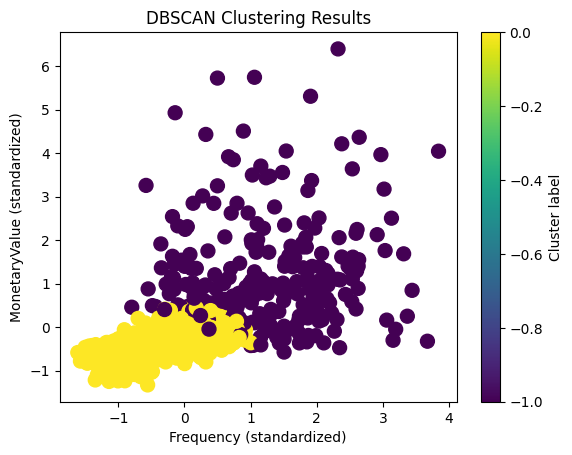

In [85]:
# 1. Import necessary libraries
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# RFM Calculation
#dbs = df2.groupby('AccountNumber').agg({
    #'AccountNumber': 'count',
    #'MoneyTransferAmount': 'sum'
#}).rename(columns={'AccountNumber': 'Frequency',
#                  'MoneyTransferAmount': 'MonetaryValue'})
# Removed the line that sets 'AccountNumber' as index since it's already the index

# Selecting only 'Frequency' and 'MonetaryValue' for clustering
X = fmb[['Frequency', 'MonetaryValue','Balance']].values  # This should now work correctly

# Standardizing the data
X_scaled = StandardScaler().fit_transform(X)

# 3. Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.4, min_samples=50).fit(X_scaled)  # Adjust eps and min_samples as needed
labels = dbscan.labels_

# 4. Visualize the results
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', marker='o', s=100)  # Color points by cluster label
plt.xlabel('Frequency (standardized)')
plt.ylabel('MonetaryValue (standardized)')
plt.title('DBSCAN Clustering Results')
plt.colorbar(label='Cluster label')
plt.show()

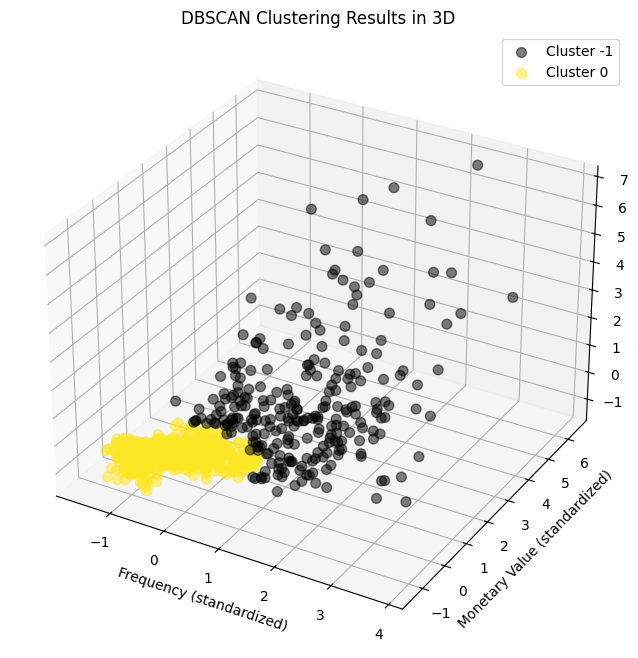

In [86]:
# 4. Visualize the results in 3D with improvements
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Get unique labels and set up the color palette
unique_labels = np.unique(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

# Plot each cluster with different color and label
for label, col in zip(unique_labels, colors):
    if label == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels == label)
    xyz = X_scaled[class_member_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=50, c=[col], alpha=0.5, label=f'Cluster {label}')

# Customize the plot
ax.set_xlabel('Frequency (standardized)')
ax.set_ylabel('Monetary Value (standardized)')
ax.set_zlabel('Balance (standardized)')
ax.set_title('DBSCAN Clustering Results in 3D')
ax.legend(loc='best')  # Add a legend to identify clusters

plt.show()

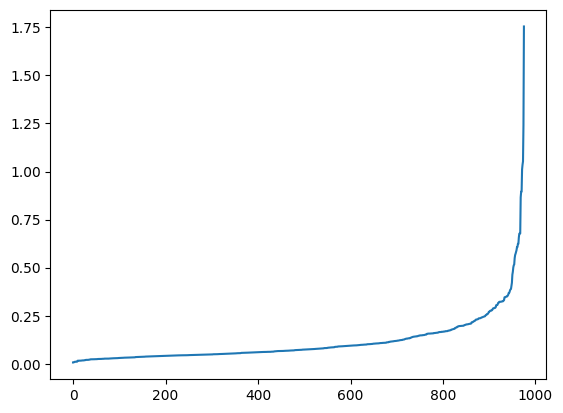

0.26995816740090955


In [69]:
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]  # Change to 1 since we're interested in the second nearest point
plt.plot(distances)
plt.show()
print(distances[900])

## Hierachacal Clustering

In [90]:
fmb.head()

,Frequency,MonetaryValue,Balance,F_Score,M_Score,RFM_Score
Account No,,,,,,
101531259.0,122,-716.08,256.662295,4,2,42
104832000.0,164,-4565.52,-1188.593268,3,1,31
105375973.0,158,-193.77,110.995337,3,3,33
106601471.0,192,10649.00,6837.358765,3,4,34
108481285.0,368,10038.92,6830.116572,1,4,14


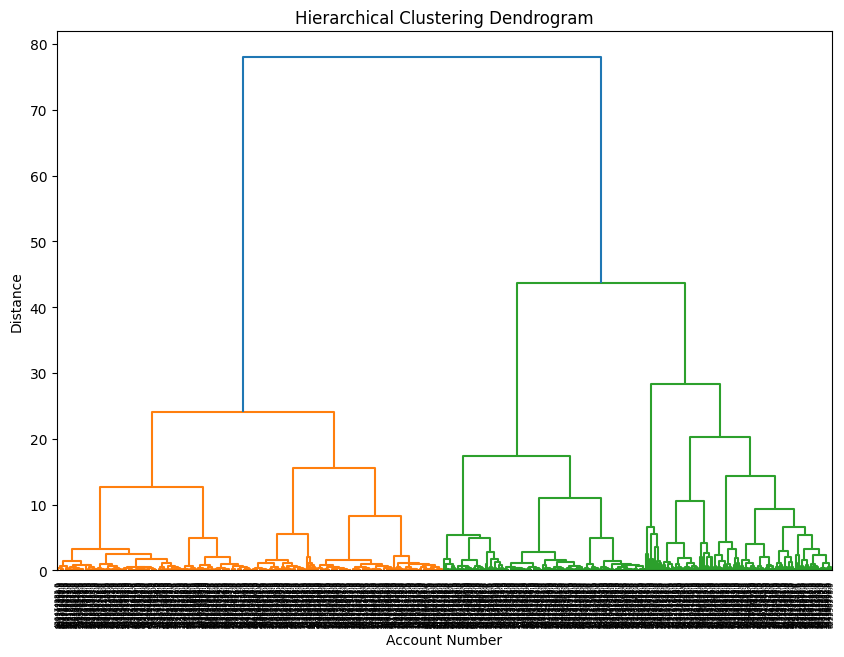

In [91]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
# Standardize the data
scaler = StandardScaler()
fmb_scaled = scaler.fit_transform(fmb)

# Perform hierarchical clustering
Z = linkage(fmb_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z, labels=fmb.index.astype(str).values)
plt.xlabel('Account Number')
plt.ylabel('Distance')
plt.show()

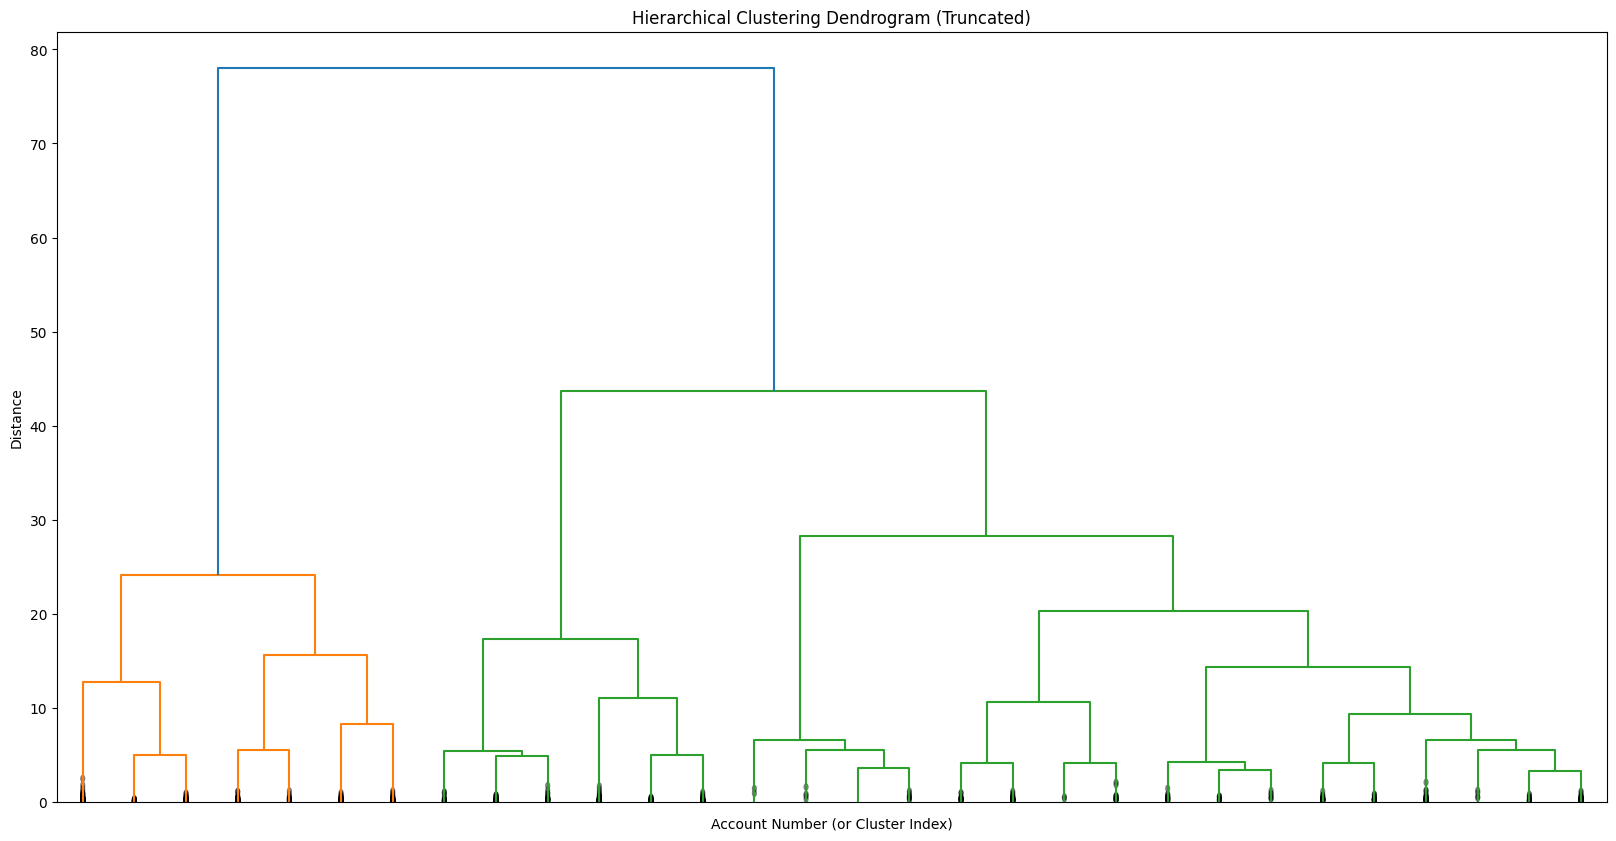

In [92]:
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,  # show only the last 30 merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.xlabel('Account Number (or Cluster Index)')
plt.ylabel('Distance')
plt.show()